In [103]:
# Steane [[7,1,3]] – Logical H with Pauli noise
# Pipeline:
#   |0_L>  --H_L-->  |+_L>  --noise-->  analyze logical fidelity

# %%
import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

from steane_encoder import steane_logical_states
from steane_noise_models import sample_iid_pauli_errors, apply_pauli_errors_to_circuit
from steane_ft_gates import apply_logical_H
from utils_states import logical_fidelity_to, is_logical_error

# Precompute logical |0_L>
logical_states = steane_logical_states()
PSI_0L = logical_states["0L"]

# Number of physical qubits in a Steane block
N_QUBITS = 7

# noise_model: "X", "Z" or "depolarizing"
NOISE_MODEL = "depolarizing"

# initial logical state and target after H_L:
#   start: |0_L>
#   gate:  H_L
#   target logical label: "+L" (i.e. H_L |0_L> = |+_L>)
INITIAL_LABEL = "0L"
TARGET_LABEL = "+L"

# Monte Carlo parameters
P_VALUES = np.linspace(0.0, 0.14, 50)   # physical error probabilities p
N_SHOTS_PER_P = 500                    # Monte Carlo shots for each p
SUCCESS_THRESHOLD = 0.99               # logical fidelity threshold


In [104]:
# %%
def _pauli_set_from_model(noise_model: str):
    """
    Map a string noise model name to a tuple of Pauli operators.
    """
    if noise_model == "X":
        return ("X",)
    elif noise_model == "Z":
        return ("Z",)
    elif noise_model == "depolarizing":
        return ("X", "Y", "Z")
    else:
        raise ValueError(f"Unknown noise model: {noise_model}")


def run_single_shot(
    p: float,
    noise_model: str = NOISE_MODEL,
    success_threshold: float = SUCCESS_THRESHOLD,
) -> dict:
    """
    Single Monte Carlo shot for:

        |0_L> --H_L--> |+_L> --Pauli noise--> final_state

    Uses Statevector.evolve instead of a backend.
    """
    pauli_set = _pauli_set_from_model(noise_model)

    # 1) Start from |0_L> statevector
    psi = PSI_0L.copy()

    # 2) Circuit with H_L + noise (no state preparation here)
    qc = QuantumCircuit(N_QUBITS)
    apply_logical_H(qc, block=range(N_QUBITS))

    # 3) Sample physical Pauli errors
    errors = sample_iid_pauli_errors(
        num_qubits=N_QUBITS,
        p=p,
        pauli_set=pauli_set,
    )

    # 4) Apply those errors
    apply_pauli_errors_to_circuit(qc, errors)

    # 5) Evolve the statevector
    psi_final = psi.evolve(qc)

    # 6) Analyze logical fidelity and error flag
    fidelity = logical_fidelity_to(psi_final, target_label=TARGET_LABEL)
    is_error = is_logical_error(
        psi_final,
        target_label=TARGET_LABEL,
        success_threshold=success_threshold,
    )

    return {
        "fidelity": fidelity,
        "is_logical_error": is_error,
    }




In [105]:
# %% [markdown]
# Logical error rate P_L(p) and average logical fidelity <F>(p)
# for Steane: no correction vs ideal correction

# %%
import matplotlib.pyplot as plt
import numpy as np




In [106]:

# Compare: no code (1 qubit) vs Steane code under the same noise model

# %%
from qiskit.quantum_info import Statevector

def run_single_shot_uncoded(
    p: float,
    noise_model: str = NOISE_MODEL,
    success_threshold: float = SUCCESS_THRESHOLD,
) -> dict:
    """
    Single-qubit baseline experiment (no error correction):

        |0> --H--> |+> --Pauli noise--> final_state
    """
    pauli_set = _pauli_set_from_model(noise_model)

    # Start from |0>
    psi0 = Statevector.from_label("0")

    # Circuit: H + noise
    qc = QuantumCircuit(1)
    qc.h(0)

    errors = sample_iid_pauli_errors(
        num_qubits=1,
        p=p,
        pauli_set=pauli_set,
    )
    apply_pauli_errors_to_circuit(qc, errors)

    # Evolve 1-qubit state
    psi_final = psi0.evolve(qc)

    # Target |+> = (|0> + |1>)/sqrt(2)
    plus = Statevector.from_label("+")
    overlap = np.vdot(plus.data, psi_final.data)
    fidelity = float(np.abs(overlap) ** 2)
    is_error = bool(fidelity < success_threshold)

    return {
        "fidelity": fidelity,
        "is_logical_error": is_error,
    }









In [107]:
# Generic experiment: choose logical gate (H/S/I) and noise model (X/Z/depolarizing)

# %%
from steane_ft_gates import apply_logical_H, apply_logical_S  # CNOT not used here

def apply_logical_gate(
    qc: QuantumCircuit,
    gate_name: str,
    block,
) -> None:
    """
    Apply a chosen logical single-qubit gate on one Steane block.

    gate_name in {"H", "S", "I"}:
      - "H": H_L = H^{⊗7}
      - "S": S_L = S^{⊗7}
      - "I": identity (do nothing)
    """
    if gate_name == "H":
        apply_logical_H(qc, block)
    elif gate_name == "S":
        apply_logical_S(qc, block)
    elif gate_name == "I":
        # identity: no gate
        return
    else:
        raise ValueError(f"Unknown logical gate: {gate_name}")


def run_single_shot_general(
    p: float,
    gate_name: str,
    noise_model: str,
    initial_label: str,
    target_label: str,
    success_threshold: float = SUCCESS_THRESHOLD,
) -> dict:
    """
    General single-shot experiment:

        |ψ_L(init)> --gate_L--> |ψ_L(target)> --noise--> final_state
    """
    pauli_set = _pauli_set_from_model(noise_model)

    # For now we always start from |0_L>
    psi = PSI_0L.copy()

    qc = QuantumCircuit(N_QUBITS)
    apply_logical_gate(qc, gate_name=gate_name, block=range(N_QUBITS))

    errors = sample_iid_pauli_errors(
        num_qubits=N_QUBITS,
        p=p,
        pauli_set=pauli_set,
    )
    apply_pauli_errors_to_circuit(qc, errors)

    psi_final = psi.evolve(qc)

    fidelity = logical_fidelity_to(psi_final, target_label=target_label)
    is_error = is_logical_error(
        psi_final,
        target_label=target_label,
        success_threshold=success_threshold,
    )

    return {
        "fidelity": fidelity,
        "is_logical_error": is_error,
    }



def run_sweep(
    gate_name: str,
    noise_model: str,
    initial_label: str,
    target_label: str,
) -> dict:
    """
    Sweep over P_VALUES for a given gate + noise model.

    Returns
    -------
    results : dict
        {
          "p_values": array,
          "P_L": array of logical error rates,
          "F_avg": array of average fidelities
        }
    """
    P_L_list = []
    F_avg_list = []

    for p in P_VALUES:
        err_count = 0
        fid_acc = 0.0

        for _ in range(N_SHOTS_PER_P):
            res = run_single_shot_general(
                p=p,
                gate_name=gate_name,
                noise_model=noise_model,
                initial_label=initial_label,
                target_label=target_label,
            )
            fid_acc += res["fidelity"]
            if res["is_logical_error"]:
                err_count += 1

        P_L_val = err_count / N_SHOTS_PER_P
        F_avg_val = fid_acc / N_SHOTS_PER_P

        P_L_list.append(P_L_val)
        F_avg_list.append(F_avg_val)

        print(
            f"[{gate_name}_L, {noise_model}] p = {p:.4f} "
            f"-> P_L ≈ {P_L_val:.5f}, <F> ≈ {F_avg_val:.5f}"
        )

    return {
        "p_values": np.array(P_VALUES, dtype=float),
        "P_L": np.array(P_L_list, dtype=float),
        "F_avg": np.array(F_avg_list, dtype=float),
    }



=== Running sweep for noise model: X ===
[H_L, X] p = 0.0000 -> P_L ≈ 0.00000, <F> ≈ 1.00000
[H_L, X] p = 0.0029 -> P_L ≈ 0.03200, <F> ≈ 0.96800
[H_L, X] p = 0.0057 -> P_L ≈ 0.02800, <F> ≈ 0.97200
[H_L, X] p = 0.0086 -> P_L ≈ 0.04400, <F> ≈ 0.95600
[H_L, X] p = 0.0114 -> P_L ≈ 0.08000, <F> ≈ 0.92000
[H_L, X] p = 0.0143 -> P_L ≈ 0.08600, <F> ≈ 0.91400
[H_L, X] p = 0.0171 -> P_L ≈ 0.12800, <F> ≈ 0.87200
[H_L, X] p = 0.0200 -> P_L ≈ 0.13200, <F> ≈ 0.86800
[H_L, X] p = 0.0229 -> P_L ≈ 0.15400, <F> ≈ 0.84600
[H_L, X] p = 0.0257 -> P_L ≈ 0.15800, <F> ≈ 0.84200
[H_L, X] p = 0.0286 -> P_L ≈ 0.18000, <F> ≈ 0.82000
[H_L, X] p = 0.0314 -> P_L ≈ 0.18200, <F> ≈ 0.81800
[H_L, X] p = 0.0343 -> P_L ≈ 0.22600, <F> ≈ 0.77400
[H_L, X] p = 0.0371 -> P_L ≈ 0.27600, <F> ≈ 0.72400
[H_L, X] p = 0.0400 -> P_L ≈ 0.20200, <F> ≈ 0.79800
[H_L, X] p = 0.0429 -> P_L ≈ 0.27800, <F> ≈ 0.72200
[H_L, X] p = 0.0457 -> P_L ≈ 0.28000, <F> ≈ 0.72000
[H_L, X] p = 0.0486 -> P_L ≈ 0.22200, <F> ≈ 0.77800
[H_L, X] p = 0.0514 ->

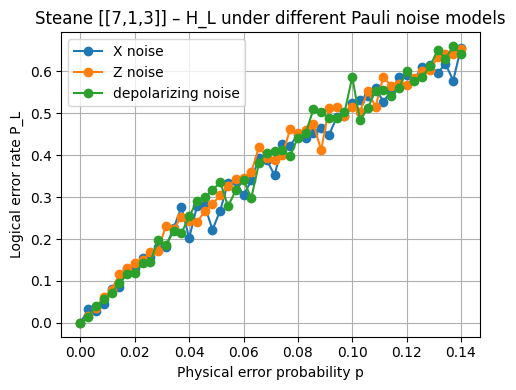

In [108]:

# Compare three noise models for H_L: X-only, Z-only, depolarizing

# %%
noise_models = ["X", "Z", "depolarizing"]
results_by_noise = {}

for nm in noise_models:
    print(f"\n=== Running sweep for noise model: {nm} ===")
    res = run_sweep(
        gate_name="H",
        noise_model=nm,
        initial_label="0L",
        target_label="+L",  # H_L |0_L> = |+_L>
    )
    results_by_noise[nm] = res



# Plot P_L(p) for each noise model

# %%
plt.figure(figsize=(5, 4))

for nm in noise_models:
    res = results_by_noise[nm]
    plt.plot(
        res["p_values"],
        res["P_L"],
        marker="o",
        label=f"{nm} noise",
    )

plt.xlabel("Physical error probability p")
plt.ylabel("Logical error rate P_L")
plt.title("Steane [[7,1,3]] – H_L under different Pauli noise models")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()


In [109]:

# Ideal Steane correction: correct any pattern of weight <= 1

# %%
from steane_noise_models import sample_iid_pauli_errors  
from steane_noise_models import apply_pauli_errors_to_circuit  

def errors_to_full_pattern(
    errors: list[tuple[int, str]],
    num_qubits: int = N_QUBITS,
) -> list[str]:
    """
    Convert a sparse list of errors [(q, 'X'), ...] into
    a full pattern ['I','I',...,'X',...,'Z'] of length num_qubits.
    """
    pattern = ["I"] * num_qubits
    for q, p in errors:
        pattern[q] = p
    return pattern


def full_pattern_to_errors(
    pattern: list[str],
) -> list[tuple[int, str]]:
    """
    Convert a full pattern ['I','X',...,'Z'] back to a sparse list
    of (qubit, Pauli) for use with apply_pauli_errors_to_circuit.
    """
    errors = []
    for q, p in enumerate(pattern):
        if p in ("X", "Y", "Z"):
            errors.append((q, p))
    return errors


def weight_pauli_pattern(pattern: list[str]) -> int:
    """
    Weight of a Pauli pattern: # of qubits with error != 'I'.
    """
    return sum(1 for e in pattern if e != "I")


def ideal_steane_correction_pattern(pattern: list[str]) -> list[str]:
    """
    Ideal Steane correction model:

      - If weight(pattern) <= 1: error is perfectly corrected
        -> return ['I'] * 7
      - If weight(pattern) >= 2: error is uncorrectable
        -> return pattern unchanged
    """
    w = weight_pauli_pattern(pattern)
    if w <= 1:
        return ["I"] * len(pattern)
    else:
        return pattern


In [110]:

# Single shot with ideal Steane correction (weight-based)

# %%
from utils_states import logical_basis_states, logical_fidelity_to

# Precompute |+_L> as target ideal state (H_L |0_L>)
logical_all = logical_basis_states()
PSI_PLUS_L = logical_all["+L"]  # ideal final state

def run_single_shot_with_correction(
    p: float,
    noise_model: str = NOISE_MODEL,
    success_threshold: float = SUCCESS_THRESHOLD,
) -> dict:
    """
    One Monte Carlo shot with ideal Steane correction:

        |0_L> --H_L--> |+_L>
                 ↓
           physical Pauli noise (IID)
                 ↓
          ideal correction:
            - if weight <= 1 -> error removed
            - if weight >= 2 -> error stays
                 ↓
           analyze fidelity to |+_L>

    Returns
    -------
    {
      "fidelity": float,
      "is_logical_error": bool
    }
    """
    pauli_set = _pauli_set_from_model(noise_model)

    # 1) Start from |0_L>
    psi = PSI_0L.copy()

    # 2) Circuit: H_L (transversal)
    qc = QuantumCircuit(N_QUBITS)
    apply_logical_H(qc, block=range(N_QUBITS))

    # 3) Sample raw errors (sparse)
    raw_errors = sample_iid_pauli_errors(
        num_qubits=N_QUBITS,
        p=p,
        pauli_set=pauli_set,
    )

    # 4) Convert to full pattern, apply ideal Steane correction,
    #    then convert back to sparse effective errors
    pattern = errors_to_full_pattern(raw_errors, num_qubits=N_QUBITS)
    effective_pattern = ideal_steane_correction_pattern(pattern)
    effective_errors = full_pattern_to_errors(effective_pattern)

    # 5) Apply effective errors to the circuit
    apply_pauli_errors_to_circuit(qc, effective_errors)

    # 6) Evolve statevector
    psi_final = psi.evolve(qc)

    # 7) Fidelity to |+_L> and logical error flag
    fidelity = logical_fidelity_to(psi_final, target_label="+L")
    is_error = bool(fidelity < success_threshold)

    return {
        "fidelity": fidelity,
        "is_logical_error": is_error,
    }


In [111]:

# Monte Carlo: Steane + H_L + ideal correction – logical error vs p

# %%
logical_error_rates_corr = []
avg_fidelities_corr = []

for p in P_VALUES:
    err_count = 0
    fid_acc = 0.0

    for _ in range(N_SHOTS_PER_P):
        res = run_single_shot_with_correction(p=p)
        fid_acc += res["fidelity"]
        if res["is_logical_error"]:
            err_count += 1

    P_L = err_count / N_SHOTS_PER_P
    F_avg = fid_acc / N_SHOTS_PER_P

    logical_error_rates_corr.append(P_L)
    avg_fidelities_corr.append(F_avg)

    print(
        f"[Steane+corr] p = {p:.4f} -> P_L ≈ {P_L:.6e}, <F> ≈ {F_avg:.6f}"
    )


[Steane+corr] p = 0.0000 -> P_L ≈ 0.000000e+00, <F> ≈ 1.000000
[Steane+corr] p = 0.0029 -> P_L ≈ 0.000000e+00, <F> ≈ 1.000000
[Steane+corr] p = 0.0057 -> P_L ≈ 2.000000e-03, <F> ≈ 0.998000
[Steane+corr] p = 0.0086 -> P_L ≈ 0.000000e+00, <F> ≈ 1.000000
[Steane+corr] p = 0.0114 -> P_L ≈ 4.000000e-03, <F> ≈ 0.996000
[Steane+corr] p = 0.0143 -> P_L ≈ 2.000000e-03, <F> ≈ 0.998000
[Steane+corr] p = 0.0171 -> P_L ≈ 1.200000e-02, <F> ≈ 0.988000
[Steane+corr] p = 0.0200 -> P_L ≈ 6.000000e-03, <F> ≈ 0.994000
[Steane+corr] p = 0.0229 -> P_L ≈ 2.000000e-03, <F> ≈ 0.998000
[Steane+corr] p = 0.0257 -> P_L ≈ 1.000000e-02, <F> ≈ 0.990000
[Steane+corr] p = 0.0286 -> P_L ≈ 2.400000e-02, <F> ≈ 0.976000
[Steane+corr] p = 0.0314 -> P_L ≈ 6.000000e-03, <F> ≈ 0.994000
[Steane+corr] p = 0.0343 -> P_L ≈ 2.000000e-02, <F> ≈ 0.980000
[Steane+corr] p = 0.0371 -> P_L ≈ 3.400000e-02, <F> ≈ 0.966000
[Steane+corr] p = 0.0400 -> P_L ≈ 3.600000e-02, <F> ≈ 0.964000
[Steane+corr] p = 0.0429 -> P_L ≈ 3.600000e-02, <F> ≈ 0

In [112]:
# %% [markdown]
# Steane [[7,1,3]] – H_L – Monte Carlo (NO correction)

# %%
logical_error_rates = []
avg_fidelities = []

for p in P_VALUES:
    error_count = 0
    fidelity_acc = 0.0

    for _ in range(N_SHOTS_PER_P):
        res = run_single_shot(p=p)  # <-- SIN corrección
        fidelity_acc += res["fidelity"]
        if res["is_logical_error"]:
            error_count += 1

    logical_error_rate = error_count / N_SHOTS_PER_P
    avg_fidelity = fidelity_acc / N_SHOTS_PER_P

    logical_error_rates.append(logical_error_rate)
    avg_fidelities.append(avg_fidelity)

    print(
        f"[Steane no corr] p = {p:.4f}  ->  P_L ≈ {logical_error_rate:.5f}, "
        f"<F> ≈ {avg_fidelity:.5f}"
    )


[Steane no corr] p = 0.0000  ->  P_L ≈ 0.00000, <F> ≈ 1.00000
[Steane no corr] p = 0.0029  ->  P_L ≈ 0.00800, <F> ≈ 0.99200
[Steane no corr] p = 0.0057  ->  P_L ≈ 0.05000, <F> ≈ 0.95000
[Steane no corr] p = 0.0086  ->  P_L ≈ 0.05800, <F> ≈ 0.94200
[Steane no corr] p = 0.0114  ->  P_L ≈ 0.09800, <F> ≈ 0.90200
[Steane no corr] p = 0.0143  ->  P_L ≈ 0.09400, <F> ≈ 0.90600
[Steane no corr] p = 0.0171  ->  P_L ≈ 0.12400, <F> ≈ 0.87600
[Steane no corr] p = 0.0200  ->  P_L ≈ 0.14400, <F> ≈ 0.85600
[Steane no corr] p = 0.0229  ->  P_L ≈ 0.17000, <F> ≈ 0.83000
[Steane no corr] p = 0.0257  ->  P_L ≈ 0.17000, <F> ≈ 0.83000
[Steane no corr] p = 0.0286  ->  P_L ≈ 0.16600, <F> ≈ 0.83400
[Steane no corr] p = 0.0314  ->  P_L ≈ 0.19400, <F> ≈ 0.80600
[Steane no corr] p = 0.0343  ->  P_L ≈ 0.22800, <F> ≈ 0.77200
[Steane no corr] p = 0.0371  ->  P_L ≈ 0.23800, <F> ≈ 0.76200
[Steane no corr] p = 0.0400  ->  P_L ≈ 0.24400, <F> ≈ 0.75600
[Steane no corr] p = 0.0429  ->  P_L ≈ 0.29800, <F> ≈ 0.70200
[Steane 

In [113]:
# %% [markdown]
# Steane [[7,1,3]] – H_L – Monte Carlo (WITH ideal correction)

# %%
logical_error_rates_corr = []
avg_fidelities_corr = []

for p in P_VALUES:
    error_count = 0
    fidelity_acc = 0.0

    for _ in range(N_SHOTS_PER_P):
        res = run_single_shot_with_correction(p=p)  # <-- CON corrección
        fidelity_acc += res["fidelity"]
        if res["is_logical_error"]:
            error_count += 1

    logical_error_rate = error_count / N_SHOTS_PER_P
    avg_fidelity = fidelity_acc / N_SHOTS_PER_P

    logical_error_rates_corr.append(logical_error_rate)
    avg_fidelities_corr.append(avg_fidelity)

    print(
        f"[Steane corr] p = {p:.4f}  ->  P_L ≈ {logical_error_rate:.5f}, "
        f"<F> ≈ {avg_fidelity:.5f}"
    )


[Steane corr] p = 0.0000  ->  P_L ≈ 0.00000, <F> ≈ 1.00000
[Steane corr] p = 0.0029  ->  P_L ≈ 0.00000, <F> ≈ 1.00000
[Steane corr] p = 0.0057  ->  P_L ≈ 0.00000, <F> ≈ 1.00000
[Steane corr] p = 0.0086  ->  P_L ≈ 0.00000, <F> ≈ 1.00000
[Steane corr] p = 0.0114  ->  P_L ≈ 0.00200, <F> ≈ 0.99800
[Steane corr] p = 0.0143  ->  P_L ≈ 0.00000, <F> ≈ 1.00000
[Steane corr] p = 0.0171  ->  P_L ≈ 0.01600, <F> ≈ 0.98400
[Steane corr] p = 0.0200  ->  P_L ≈ 0.00400, <F> ≈ 0.99600
[Steane corr] p = 0.0229  ->  P_L ≈ 0.01200, <F> ≈ 0.98800
[Steane corr] p = 0.0257  ->  P_L ≈ 0.02000, <F> ≈ 0.98000
[Steane corr] p = 0.0286  ->  P_L ≈ 0.01000, <F> ≈ 0.99000
[Steane corr] p = 0.0314  ->  P_L ≈ 0.01800, <F> ≈ 0.98200
[Steane corr] p = 0.0343  ->  P_L ≈ 0.02000, <F> ≈ 0.98000
[Steane corr] p = 0.0371  ->  P_L ≈ 0.01800, <F> ≈ 0.98200
[Steane corr] p = 0.0400  ->  P_L ≈ 0.04000, <F> ≈ 0.96000
[Steane corr] p = 0.0429  ->  P_L ≈ 0.04200, <F> ≈ 0.95800
[Steane corr] p = 0.0457  ->  P_L ≈ 0.05200, <F> ≈ 0.948

In [114]:
# %% [markdown]
# Uncoded 1-qubit baseline – Monte Carlo

# %%
phys_error_rates = []
phys_avg_fidelities = []

for p in P_VALUES:
    error_count = 0
    fidelity_acc = 0.0

    for _ in range(N_SHOTS_PER_P):
        res = run_single_shot_uncoded(p=p)
        fidelity_acc += res["fidelity"]
        if res["is_logical_error"]:
            error_count += 1

    error_rate = error_count / N_SHOTS_PER_P
    avg_fid = fidelity_acc / N_SHOTS_PER_P

    phys_error_rates.append(error_rate)
    phys_avg_fidelities.append(avg_fid)

    print(
        f"[UNCODED] p = {p:.4f} -> P_phys ≈ {error_rate:.5f}, "
        f"<F> ≈ {avg_fid:.5f}"
    )


[UNCODED] p = 0.0000 -> P_phys ≈ 0.00000, <F> ≈ 1.00000
[UNCODED] p = 0.0029 -> P_phys ≈ 0.00000, <F> ≈ 1.00000
[UNCODED] p = 0.0057 -> P_phys ≈ 0.00000, <F> ≈ 1.00000
[UNCODED] p = 0.0086 -> P_phys ≈ 0.00800, <F> ≈ 0.99200
[UNCODED] p = 0.0114 -> P_phys ≈ 0.01400, <F> ≈ 0.98600
[UNCODED] p = 0.0143 -> P_phys ≈ 0.00600, <F> ≈ 0.99400
[UNCODED] p = 0.0171 -> P_phys ≈ 0.01200, <F> ≈ 0.98800
[UNCODED] p = 0.0200 -> P_phys ≈ 0.01200, <F> ≈ 0.98800
[UNCODED] p = 0.0229 -> P_phys ≈ 0.01600, <F> ≈ 0.98400
[UNCODED] p = 0.0257 -> P_phys ≈ 0.01600, <F> ≈ 0.98400
[UNCODED] p = 0.0286 -> P_phys ≈ 0.01200, <F> ≈ 0.98800
[UNCODED] p = 0.0314 -> P_phys ≈ 0.02000, <F> ≈ 0.98000
[UNCODED] p = 0.0343 -> P_phys ≈ 0.02200, <F> ≈ 0.97800
[UNCODED] p = 0.0371 -> P_phys ≈ 0.02000, <F> ≈ 0.98000
[UNCODED] p = 0.0400 -> P_phys ≈ 0.03000, <F> ≈ 0.97000
[UNCODED] p = 0.0429 -> P_phys ≈ 0.02800, <F> ≈ 0.97200
[UNCODED] p = 0.0457 -> P_phys ≈ 0.02600, <F> ≈ 0.97400
[UNCODED] p = 0.0486 -> P_phys ≈ 0.03400, <F> ≈ 

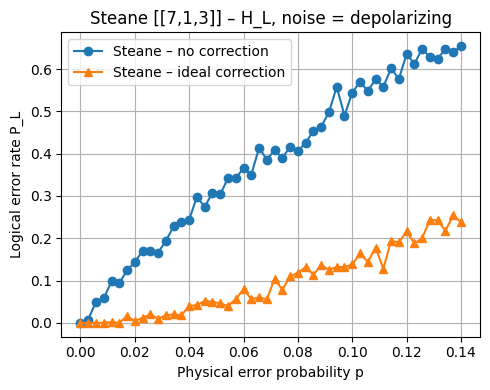

In [115]:
# %% [markdown]
# Steane – logical error rate and average fidelity (no corr vs corr)

# %%
import matplotlib.pyplot as plt
import numpy as np

p_vals = np.array(P_VALUES, dtype=float)

P_L_nocorr = np.array(logical_error_rates, dtype=float)
F_nocorr   = np.array(avg_fidelities, dtype=float)

P_L_corr = np.array(logical_error_rates_corr, dtype=float)
F_corr   = np.array(avg_fidelities_corr, dtype=float)

# P_L(p)
plt.figure(figsize=(5, 4))
plt.plot(p_vals, P_L_nocorr, marker="o", label="Steane – no correction")
plt.plot(p_vals, P_L_corr,   marker="^", label="Steane – ideal correction")
plt.xlabel("Physical error probability p")
plt.ylabel("Logical error rate P_L")
plt.title(f"Steane [[7,1,3]] – H_L, noise = {NOISE_MODEL}")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.show()




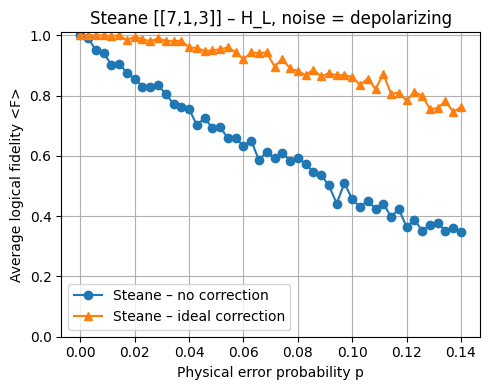

In [116]:
# <F>(p)
plt.figure(figsize=(5, 4))
plt.plot(p_vals, F_nocorr, marker="o", label="Steane – no correction")
plt.plot(p_vals, F_corr,   marker="^", label="Steane – ideal correction")
plt.xlabel("Physical error probability p")
plt.ylabel("Average logical fidelity <F>")
plt.title(f"Steane [[7,1,3]] – H_L, noise = {NOISE_MODEL}")
plt.ylim(0.0, 1.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.show()

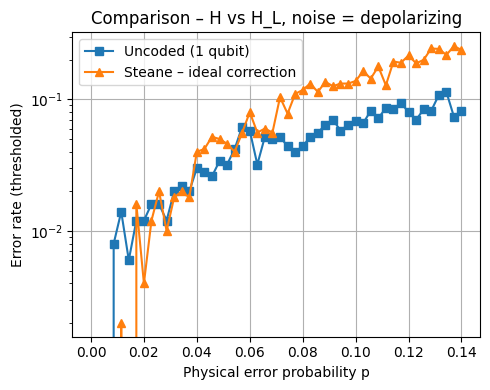

In [117]:

# Comparison – Uncoded vs Steane (no corr) vs Steane (corr)

# %%
P_phys = np.array(phys_error_rates, dtype=float)

plt.figure(figsize=(5, 4))
plt.plot(p_vals, P_phys,     marker="s", label="Uncoded (1 qubit)")
#plt.plot(p_vals, P_L_nocorr, marker="o", label="Steane – no correction")
plt.plot(p_vals, P_L_corr,   marker="^", label="Steane – ideal correction")

plt.yscale("log")  # opcional; ayuda a ver el escalado
plt.xlabel("Physical error probability p")
plt.ylabel("Error rate (thresholded)")
plt.title(f"Comparison – H vs H_L, noise = {NOISE_MODEL}")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()


In [121]:



# %%



# Monte Carlo parameters again 
P_VALUES = np.linspace(0.0, 0.14, 50)   # physical error probabilities p
N_SHOTS_PER_P = 500                    # Monte Carlo shots for each p
SUCCESS_THRESHOLD = 0.99               # logical fidelity threshold




from steane_decoder import steane_syndrome_decode
from steane_noise_models import sample_iid_pauli_errors, apply_pauli_errors_to_circuit

def run_single_shot_with_syndrome_correction(
    p: float,
    noise_model: str = NOISE_MODEL,
    success_threshold: float = SUCCESS_THRESHOLD,
) -> dict:
    """
    One Monte Carlo shot with REAL Steane syndrome correction:

        |0_L> --H_L--> |+_L>
                 ↓
           physical Pauli noise (IID)
                 ↓
        syndrome-based decoder (Steane)
                 ↓
           analyze fidelity to |+_L>

    Uses Pauli-frame correction: we never build the syndrome circuit
    explicitly, but we apply the corresponding correction Pauli.
    """
    pauli_set = _pauli_set_from_model(noise_model)

    # 1) Start from |0_L>
    psi = PSI_0L.copy()

    # 2) Circuit: H_L (transversal)
    qc = QuantumCircuit(N_QUBITS)
    apply_logical_H(qc, block=range(N_QUBITS))

    # 3) Sample raw physical errors (sparse list)
    raw_errors = sample_iid_pauli_errors(
        num_qubits=N_QUBITS,
        p=p,
        pauli_set=pauli_set,
    )

    # 4) Convert sparse errors to full Pauli pattern
    pattern = ["I"] * N_QUBITS
    for q, pchar in raw_errors:
        pattern[q] = pchar

    # 5) Syndrome-based Steane decoding on the pattern
    corrected_pattern = steane_syndrome_decode(pattern)

    # 6) Convert corrected pattern back to sparse list and apply
    corrected_errors = []
    for q, pchar in enumerate(corrected_pattern):
        if pchar != "I":
            corrected_errors.append((q, pchar))

    apply_pauli_errors_to_circuit(qc, corrected_errors)

    # 7) Evolve statevector
    psi_final = psi.evolve(qc)

    # 8) Fidelity to |+_L> and logical error flag
    fidelity = logical_fidelity_to(psi_final, target_label="+L")
    is_error = is_logical_error(
        psi_final,
        target_label="+L",
        success_threshold=success_threshold,
    )

    return {
        "fidelity": fidelity,
        "is_logical_error": is_error,
    }


In [122]:
# %% [markdown]
# Steane [[7,1,3]] – H_L – Monte Carlo (syndrome-based decoder)

# %%
logical_error_rates_synd = []
avg_fidelities_synd = []

for p in P_VALUES:
    err = 0
    fid_acc = 0.0

    for _ in range(N_SHOTS_PER_P):
        res = run_single_shot_with_syndrome_correction(p=p)
        fid_acc += res["fidelity"]
        if res["is_logical_error"]:
            err += 1

    P_L = err / N_SHOTS_PER_P
    F_avg = fid_acc / N_SHOTS_PER_P

    logical_error_rates_synd.append(P_L)
    avg_fidelities_synd.append(F_avg)

    print(f"[Steane synd] p = {p:.4f} -> P_L ≈ {P_L:.6e}, <F> ≈ {F_avg:.6f}")


[Steane synd] p = 0.0000 -> P_L ≈ 0.000000e+00, <F> ≈ 1.000000
[Steane synd] p = 0.0029 -> P_L ≈ 0.000000e+00, <F> ≈ 1.000000
[Steane synd] p = 0.0057 -> P_L ≈ 0.000000e+00, <F> ≈ 1.000000
[Steane synd] p = 0.0086 -> P_L ≈ 4.000000e-03, <F> ≈ 0.996000
[Steane synd] p = 0.0114 -> P_L ≈ 2.000000e-03, <F> ≈ 0.998000
[Steane synd] p = 0.0143 -> P_L ≈ 2.000000e-03, <F> ≈ 0.998000
[Steane synd] p = 0.0171 -> P_L ≈ 6.000000e-03, <F> ≈ 0.994000
[Steane synd] p = 0.0200 -> P_L ≈ 1.000000e-02, <F> ≈ 0.990000
[Steane synd] p = 0.0229 -> P_L ≈ 2.000000e-03, <F> ≈ 0.998000
[Steane synd] p = 0.0257 -> P_L ≈ 2.000000e-03, <F> ≈ 0.998000
[Steane synd] p = 0.0286 -> P_L ≈ 8.000000e-03, <F> ≈ 0.992000
[Steane synd] p = 0.0314 -> P_L ≈ 4.000000e-03, <F> ≈ 0.996000
[Steane synd] p = 0.0343 -> P_L ≈ 2.000000e-02, <F> ≈ 0.980000
[Steane synd] p = 0.0371 -> P_L ≈ 1.400000e-02, <F> ≈ 0.986000
[Steane synd] p = 0.0400 -> P_L ≈ 2.400000e-02, <F> ≈ 0.976000
[Steane synd] p = 0.0429 -> P_L ≈ 1.800000e-02, <F> ≈ 0

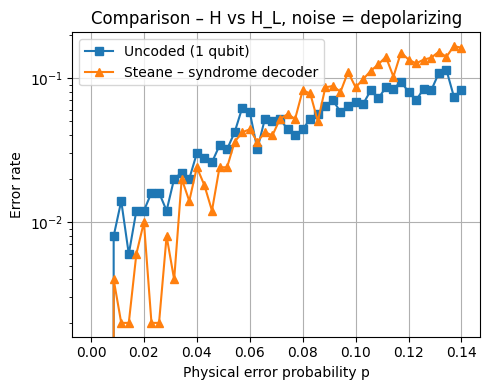

In [123]:
P_L_synd = np.array(logical_error_rates_synd, dtype=float)

plt.figure(figsize=(5, 4))
plt.plot(p_vals, P_phys,     marker="s", label="Uncoded (1 qubit)")
#plt.plot(p_vals, P_L_nocorr, marker="o", label="Steane – no correction")
plt.plot(p_vals, P_L_synd,   marker="^", label="Steane – syndrome decoder")

plt.yscale("log")
plt.xlabel("Physical error probability p")
plt.ylabel("Error rate")
plt.title(f"Comparison – H vs H_L, noise = {NOISE_MODEL}")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.show()
